# Проект "Выявление профилей потребления"

Интернет-магазин товаров для дома «Пока все ещё тут» хочет провести анализ имеющихся данных по покупателям и товарам, которые они приобретают.

Цель менеджера магазина - увеличение выручки

Задача — сегментировать покупателей по профилю потребления на основе предоставленных данных и предоставить рекомендации увеличения прибыли для менеджера

# Материалы:

- Дашборд (https://public.tableau.com/app/profile/.71835970/viz/__16924590464210/Dashboard1)

## Загрузка и предварительный анализ данных

Загрузим данные о заказах, покупателях и товарах.

Изучим данные:

- определим типы данных, все ли типы данных подходят
- оценим общую информацию: количество колонок, значений в каждой
- добавим промежуточный вывод

In [1]:
#импортируем библиотеки
import pandas as pd
pd.options.display.max_colwidth = 130
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import re
from scipy import stats as st
import numpy as np
from scipy.stats import f_oneway

In [2]:
#загружаем данные и выводим на экран
google_id = "1DkqEQWZoHh22YrsYcNUxSzlhgFqdl0tf"
data = pd.read_csv(f"https://drive.google.com/uc?export=download&id={google_id}" )
data

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
...,...,...,...,...,...,...
7469,2020013021,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт индетерминантный позднеспелый черный,2,38.0
7470,2020013022,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0
7471,2020013102,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 см AMC080,1,354.0
7472,2020013112,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цветов в кассете по 6 шт,1,128.0


В целом данные выглядят вполне нормально. Немного не в том формате тип данных в колонке date, посмотрим на данные поближе

In [3]:
#выведем общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


У нас есть 6 столбцов. На первый взгляд пропусков нет, но мы проверим это позже. Неверный формат данных в столбце date - будет необходимо заменить с int64 на datetime. Для остальных типы данных подходящие. Всего имеется 7 474 строки с данными

In [4]:
#посмотрим описание данных
data.describe()

,date,order_id,quantity,price
count,7.474000e+03,7474.000000,7474.000000,7474.000000
mean,2.018913e+09,49449.884265,2.362858,478.737501
std,4.278878e+05,32679.642404,14.500497,901.615895
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019022e+09,14833.000000,1.000000,97.000000
50%,2.019051e+09,68768.000000,1.000000,135.000000
75%,2.019063e+09,71257.750000,1.000000,439.000000
max,2.020013e+09,112789.000000,1000.000000,14917.000000


- во всех представленных числовых столбцах одинаковое количество строк
- в столбце quantity(количество товара в заказе) минимальное количество товаров - 1, максимальное - 1000. Менеджер говорил о том, что в данных самый большой заказ - тестовый и его не нужно учитывать. Поэтому позже мы исключим этот заказ из наших данных. Среднее значение количество товара в заказе - 1. В дальнейшем мы проверим этот момент - действительно ли большая часть заказов стостит из заказа 1 позиции или нет
- в столбце price (цена товара) минимальная цена товара - 9 ден. ед., в то время как максимальная - 14 917 ден. ед. Среднее значение цены равно 135 ден. ед.

In [5]:
#оценим форму датасета
data.shape

(7474, 6)

Как уже было сказано выше - мы имеем датасет в 6 столбцов и количеством строк в каждом - 7 474

### Итоги раздела

В результате загрузки и предварительного анализа данных мы имеем:

- мы имеем датасет в 6 столбцов и количеством строк в каждом - 7 474
- в столбце quantity(количество товара в заказе) минимальное количество товаров - 1, максимальное - 1000. Менеджер говорил о том, что в данных самый большой заказ - тестовый и его не нужно учитывать. Поэтому позже мы исключим этот заказ из наших данных. Среднее значение количество товара в заказе - 1.
- в столбце price (цена товара) минимальная цена товара - 9 ден. ед., в то время как максимальная - 14 917 ден. ед. Среднее значение цены равно 135 ден. ед.
- формат типа данных в колонке date необходимо изменить с int64 на datetime

Перейдем к этапу предобработки данных

## Предобработка данных

На этом этапе мы проведем такие работы:
    
- исправим типы данных, которые изначально определены неверно
- добавим столбцы с годом, месяцем, днем заказа и с суммой по каждой позиции в заказе
- проанализируем и исправим стиль написания колонок при необходимости
- произведём поиск пропущенных значений. При возможности, заполним их
- определим - есть ли дубликаты. при необходимости - удалим их
- проанализируем общую информацию о датафрейме после предобработки данных
- добавим промежуточный вывод

Нам были предоставлены данные, которые никогда не анализировались, к тому же, нет никакой гарантии, что при записи данных не было сбоев и дублирования строк

### Изменение типов данных и добавление новых столбцов

В нашем датафрейме этот этап необходим только для столбца date - с int64 на datetime. Вместе с изменением типа данных, добавим в датафрейм столбцы с годом, месяцем и днём недели, для последующей рабоы с данными. Столбец  date имеет значения в формате YYYYMMDDHH, поэтому проведем дополнительные преобразования

In [6]:
#переведём тип данных в строку и при необходиости добавим нули перед месяцем и днём
data['date'] = data['date'].astype(str).str.zfill(10)

In [7]:
#извлекаем год
data['year'] = data['date'].str.slice(0, 4)

In [8]:
#извлекаем месяц
data['month'] = data['date'].str.slice(4, 6)

In [9]:
#извлекаем день
data['day'] = data['date'].str.slice(6, 8)

In [10]:
#объединяем год, месяц и день в формат даты и приводим к нему
data['date'] = pd.to_datetime(data[['year', 'month', 'day']], format='%Y-%m-%d')
data['date'] = pd.to_datetime(data['date'])

In [11]:
#назначаем  столбцам 'year', 'month', 'day' тип данных int вместо object
data['year'] = data['year'].astype('int')
data['month'] = data['month'].astype('int')
data['day'] = data['day'].astype('int')

In [12]:
#добавим столбец  с итоговой суммой по каждой позиции в заказе
data['full_price'] = data['price'] * data['quantity']

In [13]:
#оценим преобразования датафрема
data

,date,customer_id,order_id,product,quantity,price,year,month,day,full_price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,10,1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018,10,1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018,10,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018,10,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018,10,1,112.0
...,...,...,...,...,...,...,...,...,...,...
7469,2020-01-30,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт индетерминантный позднеспелый черный,2,38.0,2020,1,30,76.0
7470,2020-01-30,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0,2020,1,30,869.0
7471,2020-01-31,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 см AMC080,1,354.0,2020,1,31,354.0
7472,2020-01-31,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цветов в кассете по 6 шт,1,128.0,2020,1,31,128.0


Все наши изменения прошли успешно, идём дальше

### Стиль колонок

В дальнейшем исследовании нам будет необходимо разбить товары на категории. Учитывая, что в столбце product есть товары, которые начинаются с заглавной буквы, а некоторые с прописной - чтобы легче категоризировать приведем все названия товаров к нижнему регистру

In [14]:
#приведем названия товаров к нижнему регистру
data['product'] = data['product'].str.lower()

перейдем к следующему пункту - поиску пропущенных значений

### Поиск пропущенных значений

Исследуем, есть ли пропущенные значения в строках датафрейма

In [15]:
#проведем поиск пропущенных значений
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
year           0
month          0
day            0
full_price     0
dtype: int64

Пропущенных значений нет. Перейдем к поиску дубликатов

### Поиск дубликатов

Так как у нас достаточно небольшой датафрейм по количеству столбцов, проверим наличие строк-дубликатов по столбцам ('date', 'customer_id', 'order_id', 'product')

In [16]:
#зададим поиск дубликатов
duplicates = data.duplicated(subset=['customer_id', 'order_id', 'product'])
if duplicates.any():
    print("дубликаты найдены")
else:
    print("дубликаты не найдены")

дубликаты найдены


In [17]:
#посмотрим на строки-дубликаты
data[duplicates]

,date,customer_id,order_id,product,quantity,price,year,month,day,full_price
58,2018-10-02,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 см металлическая сетка 35748w,1,3299.0,2018,10,2,3299.0
59,2018-10-02,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 см металлическая сетка 35748w,1,3299.0,2018,10,2,3299.0
60,2018-10-02,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 см металлическая сетка 35748w,1,3299.0,2018,10,2,3299.0
63,2018-10-03,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 см металлическая сетка 35748w,1,3299.0,2018,10,3,3299.0
94,2018-10-04,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,1409.0,2018,10,4,1409.0
...,...,...,...,...,...,...,...,...,...,...
6706,2019-10-28,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,сумка-тележка 2-х колесная gimi argo красная,1,1087.0,2019,10,28,1087.0
6711,2019-10-28,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,мирт d-9 см h-15 см,1,134.0,2019,10,28,134.0
6728,2019-10-31,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1404021",1,397.0,2019,10,31,397.0
6729,2019-10-31,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1404021",1,397.0,2019,10,31,397.0


Мы нашли 1886 строк-дубликатов. Это достаточно большое количество для такого датафрейма как наш (в 7 474 строки). Но как мы уже обсуждали выше - эти данные никогда не проходили анализ. Возможно, в работе приложения есть периодические технические сбои, которые задваивают заказы. Мы удалим данные дубликаты, а в конце направим рекомендацию для технического отдела нашего приложения - проанализировать техническую часть при формировании и оформлении заказа 

In [18]:
#удалим дубликаты
data.drop_duplicates(subset=['customer_id', 'order_id', 'product'], inplace=True)

In [19]:
#проверим, остались ли еще дубликаты
duplicates = data.duplicated(subset=['customer_id', 'order_id', 'product'])
if duplicates.any():
    print("дубликаты найдены")
else:
    print("дубликаты не найдены")

дубликаты не найдены


Дубликатов-строк больше не осталось. Необходимо добавить проверку что каждому номеру заказа - назначен только 1 покупатель

In [20]:
#определим заказы, которые при одинаковых данных имеют больше одного покупателя
bug_orders = data.groupby('order_id').agg({'customer_id': 'nunique'}).query('customer_id > 1')
bug_orders

,customer_id
order_id,
14872,2
68785,2
69283,2
69310,2
69345,2
69410,2
69485,3
69531,2
69833,2


У нас есть 29 заказов, которым присвоены больше чем 1 покупатель. Посмотрим более детально

In [21]:
#посмотрим на заказ из списка более детально
data[data['order_id'] == 71480]

,date,customer_id,order_id,product,quantity,price,year,month,day,full_price
3963,2019-05-21,4bd9c1e8-b2cc-4ec5-97eb-28d8f3c22d8d,71480,мята перечная шоколадная chocolate d-7 см h-10 см укорененный черенок,1,74.0,2019,5,21,74.0
4025,2019-05-24,d8080f8f-3685-433b-b416-beb0a8f06606,71480,мята перечная шоколадная chocolate d-7 см h-10 см укорененный черенок,1,74.0,2019,5,24,74.0
4026,2019-05-25,51f04abe-a71a-4694-87b7-ad9ef4930e51,71480,мята перечная шоколадная chocolate d-7 см h-10 см укорененный черенок,1,74.0,2019,5,25,74.0


Как видно, заказ №71480 имеет одинаковый товар, но 3 различные id-покупателя и даты. 

Вероятно, технический сбой  привел к тому, что id-заказа стало одинаковым в 3-х разных заказах, или сбой привел к изменению id-покупателя в одном и том же заказе.

На данный момент у нас нет возможности дать ответ - сделаны эти заказы разными покупателями или нет, поэтому  мы удалим строки дублирующихся заказов. Так как неизвестно, когда и по какой причине возникла техническая ошибка, которая привела к сбою в данных - будем оставлять последнее изменение заказа (последнюю строку)

In [22]:
#удалим строки 
data = data.drop(index=[5518, 5519, 5520, 512, 1154, 1177, 1196, 1237, 1282, 1292, 1323, 1519, 1706, 2118, 2211, 2322,
                       2409, 2491, 2579, 2720, 2996, 3932, 3963, 4025, 4089, 4297, 4909, 5020, 6026, 6440, 6447, 6504, 
                       6505, 6508, 6601])

In [23]:
#проверим еще раз, остались ли заказы, которые при одинаковых данных имеют больше одного покупателя
bug_orders_new = data.groupby('order_id').agg({'customer_id': 'nunique'}).query('customer_id > 1')
bug_orders_new

,customer_id
order_id,


Проверим так же, есть ли заказы с одним id но с разными датами

In [24]:
#проверим еще раз, остались ли заказы, которые при одинаковых id имеют разные даты
bug_orders_second = data.groupby('order_id').agg({'date': 'nunique'}).query('date > 1')
bug_orders_second

,date
order_id,
14500,2
14898,2
69527,2
69750,2
69807,2
70186,2
70318,2
70995,2
71143,2


In [25]:
#посмотрим на заказ из списка более детально
data[data['order_id'] == 14500]

,date,customer_id,order_id,product,quantity,price,year,month,day,full_price
482,2018-10-28,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,"многолетнее растение душица-орегано розовый объем 0,5 л",1,89.0,2018,10,28,89.0
483,2018-10-28,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,"многолетнее растение тимьян-чабрец розовый объем 0,5 л",1,89.0,2018,10,28,89.0
484,2018-10-28,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,пеларгония зональная диам. 12 см белая полумахровая,1,188.0,2018,10,28,188.0
485,2018-10-28,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,пеларгония зональная диам. 12 см розовая с малиновым полумахровая,1,188.0,2018,10,28,188.0
486,2018-10-28,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,пеларгония зональная диам. 12 см сиреневый полумахровый,1,188.0,2018,10,28,188.0
487,2018-10-28,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,пеларгония зональная диам. 12 см ярко красная махровая,1,188.0,2018,10,28,188.0
488,2018-10-28,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,"рассада зелени для кухни базилик арарат, кассета по 6шт",1,169.0,2018,10,28,169.0
489,2018-10-28,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,рассада зелени для кухни лаванды в горшке диам. 9 см,1,101.0,2018,10,28,101.0
490,2018-10-28,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,рассада зелени для кухни розмарина в кассете по 6 шт,1,210.0,2018,10,28,210.0
550,2018-10-31,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,рассада зелени для кухни розмарина в горшке диам. 9 см,1,101.0,2018,10,31,101.0


Как видно, один и тот же покупатель сделал большой заказ 28 октября, 29 октября он добавил еще один товар(с другим названием) но эта позиция не получила своего отдельного id-заказа, а была прикреплена к заказу с предыдущего дня.

Так как здесь уже указаны разные позиции, мы не можем просто удалить строку. Вместо этого дадим заказу другой id. Для этого сначала узнаем максимальное значение id-заказа

Проанализируем всё дублеры, и исправим заказы

In [26]:
#определим максимальное значение id-заказа
data['order_id'].max()

112789

In [27]:
#назначим заказам новые номера
data.loc[550, 'order_id'] = 112790
data.loc[5803, 'order_id'] = 112791
data.loc[1351, 'order_id'] = 112792
data.loc[1814, 'order_id'] = 112793
data.loc[1807, 'order_id'] = 112794
data.loc[1802, 'order_id'] = 112795
data.loc[1938, 'order_id'] = 112796
data.loc[2743, 'order_id'] = 112797
data.loc[2948, 'order_id'] = 112798
data.loc[3797, 'order_id'] = 112799

In [28]:
#проверим еще раз, остались ли заказы, которые при одинаковых id имеют разные даты
bug_orders_repeat = data.groupby('order_id').agg({'date': 'nunique'}).query('date > 1')
bug_orders_repeat

,date
order_id,


Все дублирующие строки были удалены. Так же удалим в этом разделе тестовый заказ менеджера магазина

### Удаление тестового заказа менеджера

In [29]:
#найдем тестовый заказ
test_order = data.nlargest(1, 'quantity')
test_order

,date,customer_id,order_id,product,quantity,price,year,month,day,full_price
5456,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, burstenmann, 0522/0000",1000,675.0,2019,6,18,675000.0


In [30]:
#удалим строку с ним
data = data.drop(index=5456)

Мы нашли и удалили тестовый заказ менеджера. Предобработка данных подошла к концу

### Анализ общей информации

Оценим, что получилось в результате предобработки данных

In [31]:
#посмотрим на датасет в общем
data

,date,customer_id,order_id,product,quantity,price,year,month,day,full_price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018,10,1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,2018,10,1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018,10,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018,10,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018,10,1,112.0
...,...,...,...,...,...,...,...,...,...,...
7469,2020-01-30,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт индетерминантный позднеспелый черный,2,38.0,2020,1,30,76.0
7470,2020-01-30,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0,2020,1,30,869.0
7471,2020-01-31,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 см amc080,1,354.0,2020,1,31,354.0
7472,2020-01-31,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цветов в кассете по 6 шт,1,128.0,2020,1,31,128.0


Мы добавили новые столбцы, в целом, данные выглядят хорошо

In [32]:
#посмотрим типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5552 entries, 0 to 7473
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5552 non-null   datetime64[ns]
 1   customer_id  5552 non-null   object        
 2   order_id     5552 non-null   int64         
 3   product      5552 non-null   object        
 4   quantity     5552 non-null   int64         
 5   price        5552 non-null   float64       
 6   year         5552 non-null   int64         
 7   month        5552 non-null   int64         
 8   day          5552 non-null   int64         
 9   full_price   5552 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 477.1+ KB


Типы данных подходят

In [33]:
#оценим размер датасета
data.shape

(5552, 10)

В результате предобработки размер датасета сократился на 25,7%. Это достаточно большой показатель, но, учитывая, что данные не были ни разу обработаны - такое количество удаленных данных является нормальным.

По итогам предобработки, мы сохранили датасет на 74,3% и увеличили количество столбцов с 6 до 10

### Итоги раздела

В результате предобработки данных было выполнено:

- столбец "date" приведён в верный формат данных - datetime64
- добавлены и приведены в нужный формат новые столбцы: "год", "месяц", "день", "итоговая цена"
- данные в столбце "product" приведены в нижний регистр
- удалён тестовый заказ менеджера
- удалены дубликаты
- проведен поиск пропущенных значений
- в результате предобработки, датасет сохранён на 74,3% и увеличено количество столбцов с 6 до 10

## Исследовательский анализ данных

На этом этапе исследования поставлены такие задачи:

- определим даты первого и последнего заказа в наших данных. Узнаем, какой временный промежуток представлен в данных
- определим количество уникальных пользователей приложения, количество заказов и рассчитаем среднее количество заказов на одного покупателя
- исследуем, как изменяется количество заказов каждый месяц. Добавим визуализацию
- исследуем, как меняется выручка от заказов каждый месяц. Добавим визуализацию
- исследуем, как меняется средний чек заказов каждый месяц. Добавим визуализацию
- сформулируем промежуточный вывод

### Определение временного промежутка в данных

In [34]:
#определим минимальную дату заказа
data['date'].min()

Timestamp('2018-10-01 00:00:00')

In [35]:
#определим максимальную дату заказа
data['date'].max()

Timestamp('2020-01-31 00:00:00')

У нас есть данные по заказам из приложения с 1 октября 2018 по 31 января 2020 года. В целом около 1,5 года

### Покупатели и заказы

In [36]:
#определим количество уникальных покупателей
costumers = data['customer_id'].nunique()
costumers

2429

За указанный промежуток времени в приложении делали заказ 2 429 человек

In [37]:
#определим количество заказов
orders = data['order_id'].nunique()
orders

3530

Было совершено 3 530 заказов

In [38]:
#определим соотношение количества заказов на количество покупателей
events = round(orders / costumers, 2)
events

1.45

В среднем, на одного покупателя приходится примерно 1,5 заказа. Это достаточно интересная информация

### Изменение количества заказов ежемесячно

In [39]:
#рассчитаем количество заказов каждый месяц
orders_by_month = data.groupby(['year','month']).agg({'order_id': 'nunique'})
orders_by_month

order_id
year month          
2018 10          240
     11          204
     12          283
2019 1           167
     2           290
     3           246
     4           267
     5           183
     6           160
     7           199
     8           174
     9           181
     10          204
     11          217
     12          246
2020 1           269

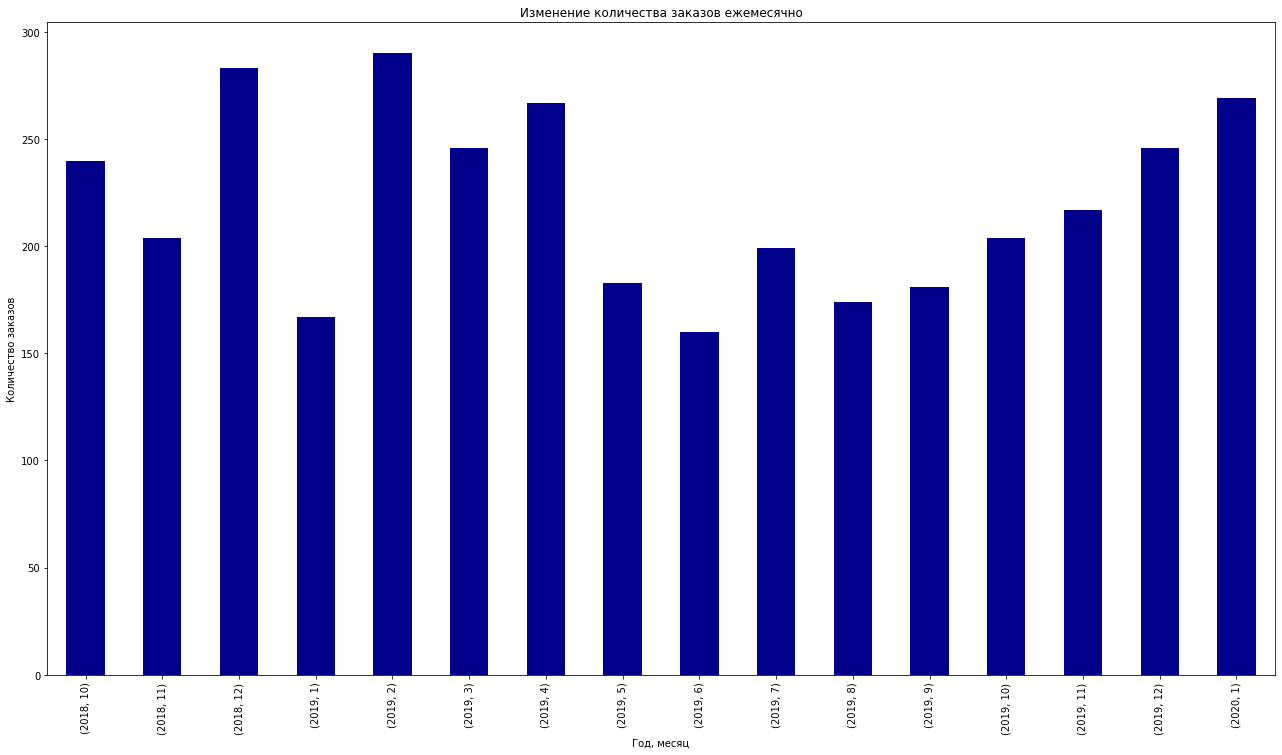

In [40]:
#построим график
orders_by_month.plot(kind='bar', figsize=(22, 12), color='darkblue', legend=False)
plt.title('Изменение количества заказов ежемесячно')
plt.xlabel('Год, месяц')
plt.ylabel('Количество заказов')
plt.show()

С начала  изучения данных количество заказов нестабильно - первые 7 месяцев количество заказов ежемесячно растёт и падает. 

- наибольшее количество заказов было в феврале 2019 года - 290
- наименьшее количество в июле 2019 - 160
- начиная с августа 2019 год количество заказов стабильно растёт

### Изменение выручки от заказов ежемесячно

Посмотрим, как изменятся выручка от заказов каждый месяц на протяжении изучаемого периода

In [41]:
#рассчитаем сумму выручки каждый месяц
revenue_by_month = round(data.groupby(['year','month']).agg({'full_price': 'sum'}), 0)
revenue_by_month

full_price
year month            
2018 10       351536.0
     11       359348.0
     12       348399.0
2019 1        234834.0
     2        306796.0
     3        251457.0
     4        317038.0
     5        235866.0
     6        226811.0
     7        234932.0
     8        172421.0
     9        179509.0
     10       210924.0
     11       128792.0
     12       202885.0
2020 1        174036.0

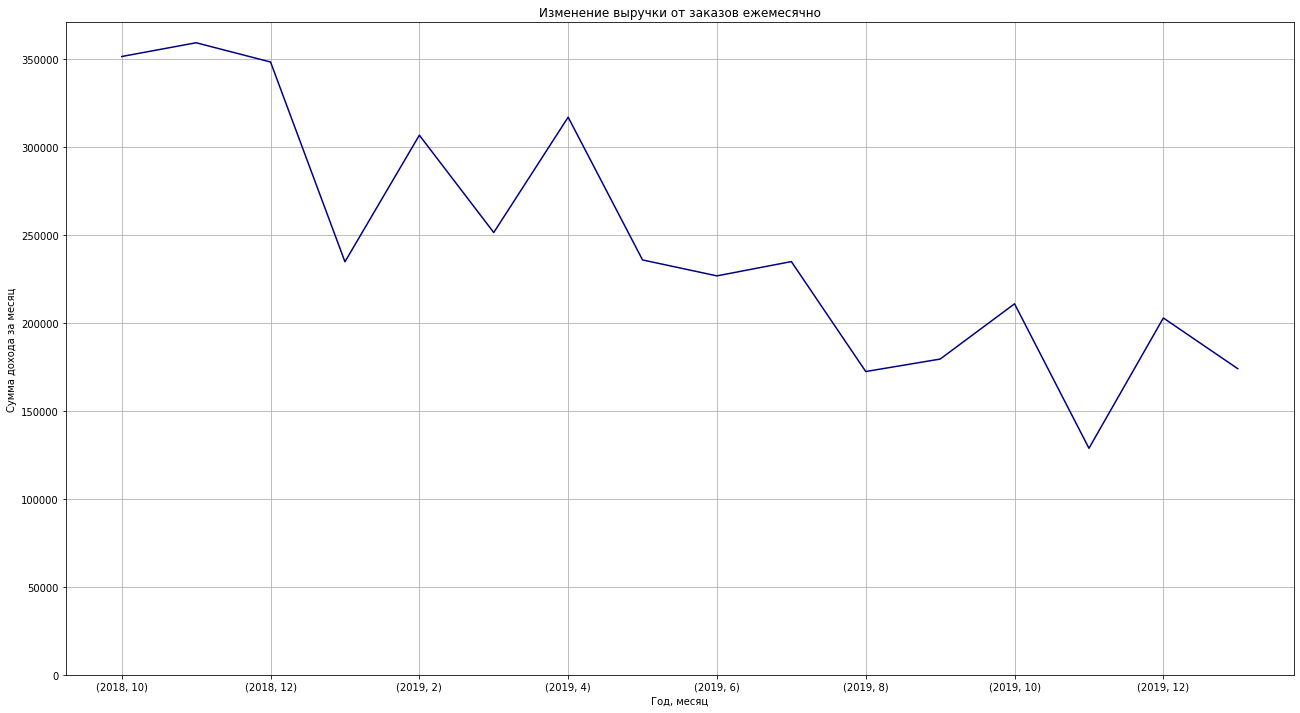

In [42]:
#построим график
revenue_by_month.plot(figsize=(22, 12), color='navy', grid=True, legend=False)
plt.title('Изменение выручки от заказов ежемесячно')
plt.xlabel('Год, месяц')
plt.ylabel('Сумма дохода за месяц')
plt.ylim(bottom=0)
plt.show()

Исходя из представленных данных видно, что первые 3 месяца работы приложения имели хороший доход

- начиная с января 2019 года наиболее доходными месяцами были февраль (306 796 ден. ед) и апрель (317 038 ден. ед)
- в остальные месяцы выручка составила менее 250 000 ден. ед.
- ноябрь 2019 был наихудшим месяцем по выручке - 128 792 ден. ед
- На 31 января 2020 года выручка в 2 раза меньше, чем была в первый месяц работы приложения - октябрь 2018. Причины такого снижения пока непонятны

### Изменение среднего чека заказов ежемесячно

Исследуем как меняется сумма среднего чека по заказам ежемесячно. Для этого сначала добавим новый столбец - который будет показывать общую сумму каждого заказа

In [43]:
#рассчитаем значение среднего чека каждый месяц
mean_revenue_by_month = round(data.groupby(['year', 'month',
                                            'order_id'])['full_price'].sum().groupby(['year', 'month']).mean(), 0)
mean_revenue_by_month

year  month
2018  10       1465.0
      11       1762.0
      12       1231.0
2019  1        1406.0
      2        1058.0
      3        1022.0
      4        1187.0
      5        1289.0
      6        1418.0
      7        1181.0
      8         991.0
      9         992.0
      10       1034.0
      11        594.0
      12        825.0
2020  1         647.0
Name: full_price, dtype: float64

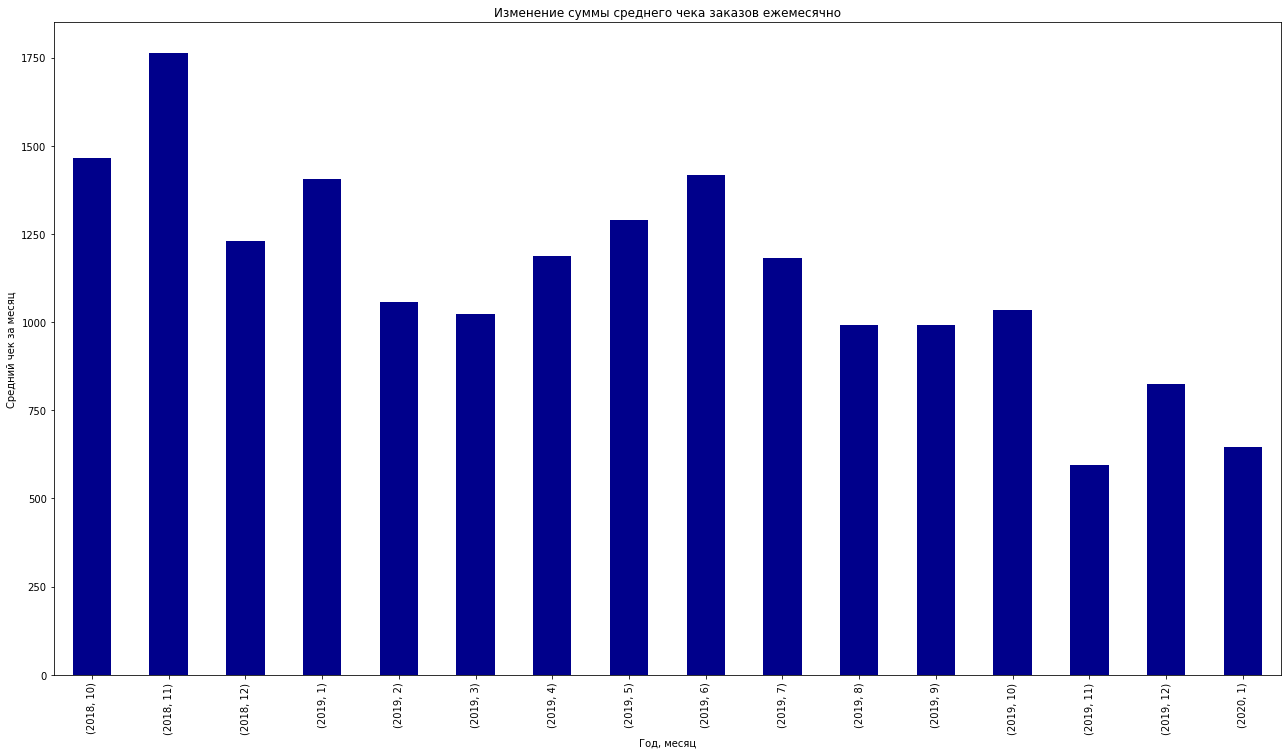

In [44]:
#построим график
mean_revenue_by_month.plot(kind='bar', figsize=(22, 12), color='darkblue', legend=False)
plt.title('Изменение суммы среднего чека заказов ежемесячно')
plt.xlabel('Год, месяц')
plt.ylabel('Средний чек за месяц')
plt.show()

В результате:

- изменение среднего чека имеет достаточно хаотичный порядок
- наивысшее значение ср. чека было в ноябре 2018 - 1 762 ден. ед.
- в 2019 году было 2 основных пика значений - январь (1 408) и июнь(1 418)
- наименьшее значение быо в ноябре 2019 года - 594 ден. ед.

### Динамика изменения количествa покупателей каждый месяц

Проанализируем количество уникальных покупателей, которые делают заказы - как меняется их количество каждый месяц

In [45]:
#сгруппируем данные
customers_by_month = data.groupby(['year', 'month']).agg({'customer_id': 'nunique'})
customers_by_month

customer_id
year month             
2018 10             180
     11             178
     12             232
2019 1              151
     2              246
     3              231
     4              236
     5              168
     6              150
     7              186
     8              165
     9              173
     10             175
     11             217
     12             246
2020 1              269

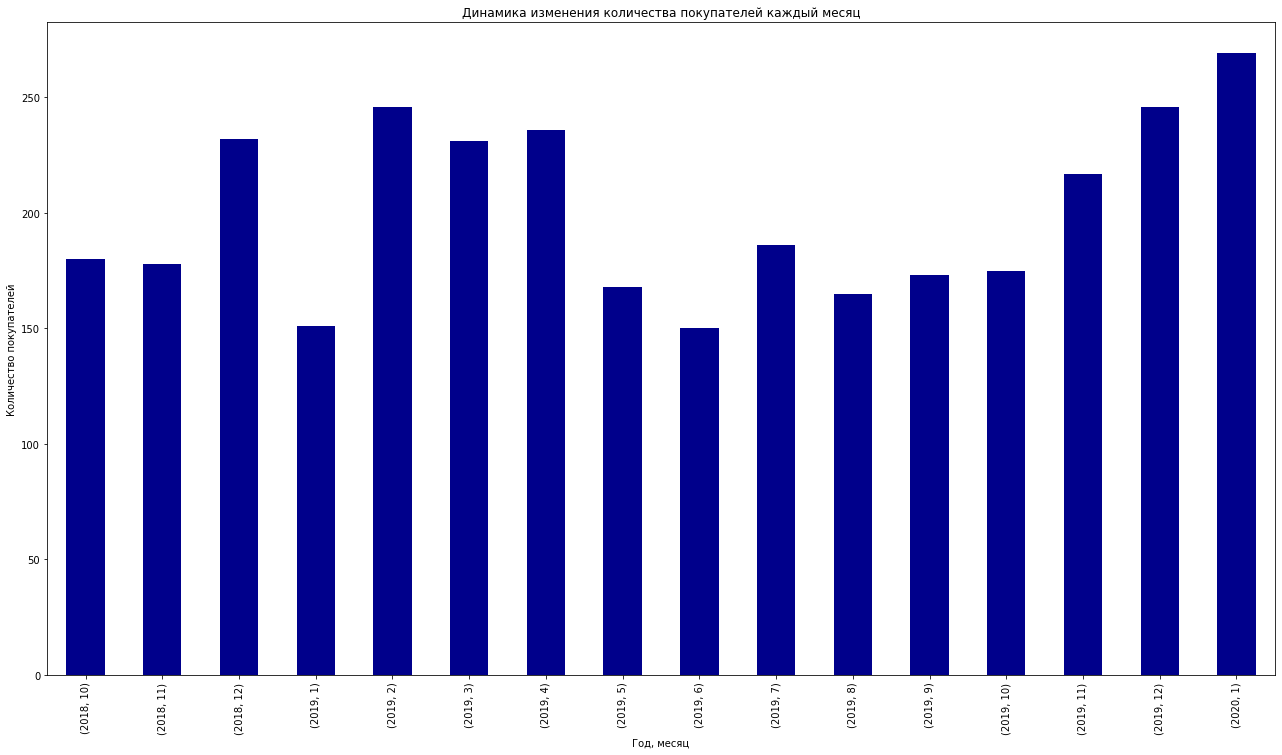

In [46]:
#построим график
customers_by_month.plot(kind='bar', figsize=(22, 12), color='darkblue', legend=False)
plt.title('Динамика изменения количества покупателей каждый месяц')
plt.xlabel('Год, месяц')
plt.ylabel('Количество покупателей')
plt.show()

Анализируя данные графика:

- количество пользователей начиная с августа 2019 года растет. Это вполне хороший показатель
- первые полгода количество покупателей имело скачкообразный характер - больше пользователей пользовались приложением в декабре, феврале, марте и апреле

### Итоги раздела

В результате проведения исследовательского анализа данных было определено:

- нам представлены данные по заказам из приложения с 1 октября 2018 по 31 января 2020 года
- за указанный промежуток времени в приложении делали заказ 2 429 человек
- было совершено 3 530 заказов
- в среднем, на одного покупателя приходится 1 заказ

Количество заказов:
- первые 7 месяцев работы приложения количество заказов было нестабильно - оно постоянно росло и снижалось
- с февраля по апрель 2019 года количество заказов было на порядок выше, чем с мая по ноябрь этого же года
- с августа 2019 года количество заказов стабильно растёт

Изменение выручки по месяцам:
- с октября по декабрь 2018 года доход был довольно высокий - более 340 000 ден.ед.
- начиная с января 2019 года выручка имеет пиковые значения, но постоянно снижается. Сумма выручки не превышает 318 000 ден. ед.
- в отличии от периода октябрь-декабрь 2018 года - аналогичный период 2019 года характеризуется значительным снижением прибыли

Ежемесячное изменение суммы среднего чека заказа:
- изменение среднего чека имеет достаточно хаотичный порядок
- наивысшее значение ср. чека было в ноябре 2018 - 1 762 ден. ед.
- в 2019 году было 2 основных пика значений - январь (1 408) и июнь(1 418)
- наименьшее значение быо в ноябре 2019 года - 594 ден. ед.

Ежемесячное изменение количествa покупателей каждый месяц:
- количество пользователей начиная с августа 2019 года растет. Это вполне хороший показатель
- первые полгода количество покупателей имело скачкообразный характер - больше пользователей пользоваись приложением в декабре, феврале, марте и апреле

##  Сегментация покупателей

В этом разделе мы проведем категоризацию покупателей и заказов по разным данным:

- сгруппируем данные по каждому заказу. Проанализируем стоимость заказов. На основе определенных сумм - разработаем категории заказов. Сгруппируем данные заказов по категориям и определим - какие заказы и с какими суммами пользователи делают чаще. 
- сгруппируем данные по каждому пользователю. На основе этих данных - разработаем категории (по количеству заказов, сделанных каждым пользователем). Сгруппируем данные на основе категорий и исследуем - какое количество заказов делает каждый пользователь. 
- добавим столбец с категориями товаров(например: комнатные растения, рассада, кухонные принадлежности, декор, хозяйственные принадлежности и пр.) Исследуем, какие категории товаров приобретаются пользователями чаще и приносят большую прибыль. Рассчитаем общую прибыль и среднюю цену для каждой категории товаров. 
- на основе полученных данных составим портрет лояльного покупателя: наиболее прибыльные категории товаров, количество заказов и пр
- сформулируем промежуточный вывод

### Категории заказов по суммам

Для этой задачи мы сгруппируем наши заказы по суммам и создадим функцию, которая разделит заказы по категориям. Определим такие категории:

- первая - сумма заказов которых не превышает 500 ден. ед.
- вторая - сумма заказов которых не превышает 1000 ден. ед.
- третья - сумма заказов которых не превышает 2000 ден. ед.
- четвертая - сумма заказов которых не превышает 3000 ден. ед.
- пятая - сумма заказов которых не превышает 4000 ден. ед.
- шестая - сумма заказов которых не превышает 5000 ден. ед.
- седьмая - сумма заказа более 5000 ден. ед.

In [47]:
#сгруппируем заказы по суммам выручки
orders_category = data.groupby('order_id').agg({'full_price': 'sum'}).reset_index()
orders_category

,order_id,full_price
0,12624,375.0
1,13547,684.0
2,14480,359.0
3,14481,600.0
4,14482,376.0
...,...,...
3525,112795,1574.0
3526,112796,637.0
3527,112797,749.0
3528,112798,59.0


In [48]:
#создадим функцию
def category(full_price):
    if full_price <= 500:
        return 'первая'
    elif full_price <= 1000:
        return 'вторая'
    elif full_price <= 2000:
        return 'третья'
    elif full_price <= 3000:
        return 'четвертая'
    elif full_price <= 4000:
        return 'пятая'
    elif full_price <= 5000:
        return 'шестая'
    else:
        return 'седьмая'

In [49]:
#добавим столбец категорий в наш датасет
data['category'] = data.apply(lambda row: category(row['full_price']), axis=1)

In [50]:
#сгруппируем заказы по категориям
orders_categories = data.groupby('category').agg({'order_id': 'nunique'}).sort_values(by='order_id', ascending=False)
orders_categories

,order_id
category,
первая,1894
вторая,684
третья,595
четвертая,197
пятая,102
седьмая,101
шестая,43


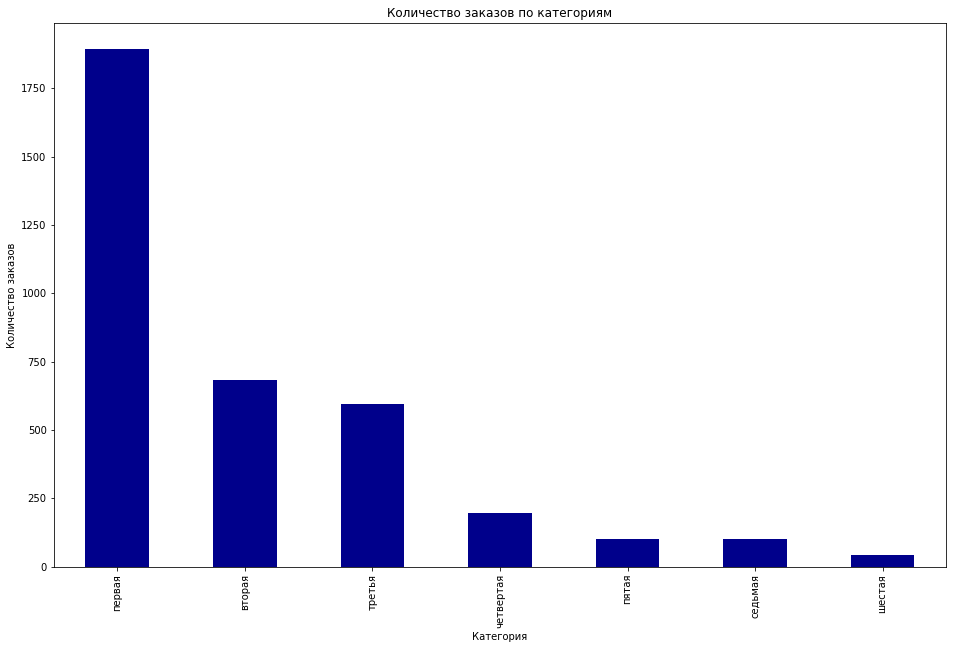

In [51]:
#построим график
orders_categories.plot(kind='bar', figsize=(16, 10), color='darkblue', legend=False)
plt.title('Количество заказов по категориям')
plt.xlabel('Категория')
plt.ylabel('Количество заказов')
plt.show()

- преимущественное количество заказов по сумме не превышает 500 ден. ед. Таких заказов у нас 1 894
- категории заказов до 1 000 - 2 000 ден. ед. имеют примерные значения - 684 и 595 заказов
- а самая дорогостоящая категория - более 5 000 ден. ед. имеет всего 43 заказа


В целом можно сказать, что покупатели гораздо чаще делают небольшие и недорогие заказы

### Категории пользователей по количеству заказов

В этом пункте мы разделим покупателей в приложении на категории согласно количеству осуществленных заказов. Категории будут следующие:

- единоразовый - пользователь сделал 1 заказ за всё время
- повторный - покупатель совершил  2 заказа
- периодичный - пользователь сделал 3 или более заказов

In [52]:
#создадим функцию
def user_type(count_orders):
    if count_orders == 1:
        return 'единоразовый'
    elif count_orders == 2:
        return 'повторный'
    else:
        return 'периодичный'

In [53]:
#группируем данные пользователей по количеству совершенных заказов 
count_orders = data.groupby('customer_id').agg({'order_id': 'nunique'}).reset_index()
count_orders

,customer_id,order_id
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1
1,001cee7f-0b29-4716-b202-0042213ab038,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1
...,...,...
2424,ff601403-b094-4b86-9ac6-264d725b9277,2
2425,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1
2426,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1
2427,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1


In [54]:
#объеденим таблицу с количеством заказов у каждого пользователя с датафреймом
data = pd.merge(data, count_orders, on='customer_id')

In [55]:
#добавим столбец в датафрейм
data['user_type'] = data['order_id_y'].apply(user_type)

In [56]:
#удалим ненужный столбец
data.drop('order_id_y', axis=1, inplace=True)


In [57]:
#
data = data.rename(columns={'order_id_x': 'order_id'})

In [58]:
#группируем заказы по категориям
customer_type = data.groupby('user_type').agg({'customer_id': 'nunique'}).sort_values(by='customer_id', ascending=False)
customer_type

,customer_id
user_type,
единоразовый,1535
повторный,865
периодичный,29


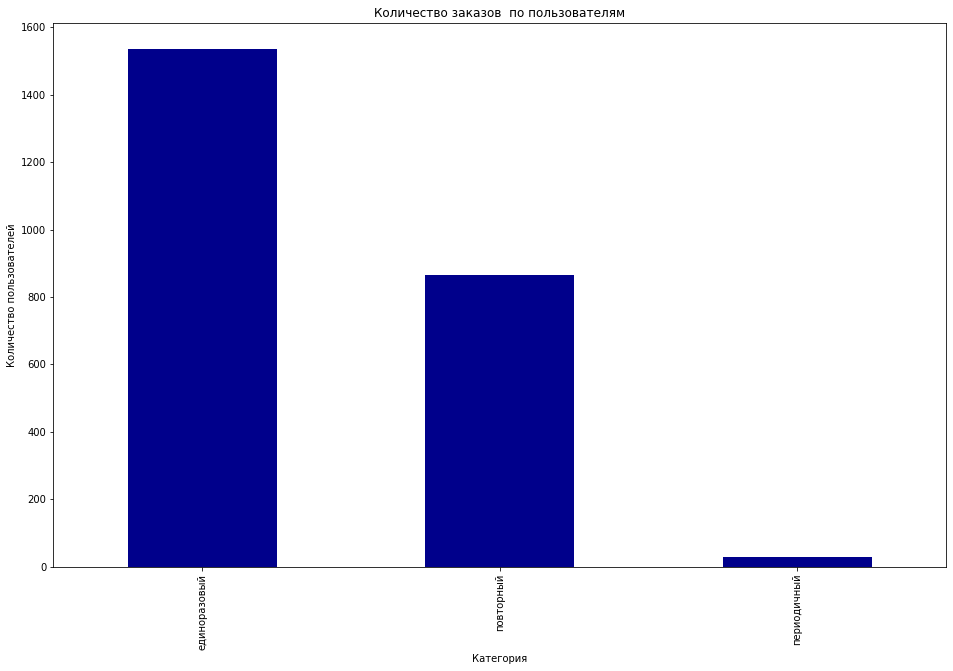

In [59]:
#построим график
customer_type.plot(kind='bar', figsize=(16, 10), color='darkblue', legend=False)
plt.title('Количество заказов  по пользователям')
plt.xlabel('Категория')
plt.ylabel('Количество пользователей')
plt.show()

Исходя из данных:

- наибольшее количество пользователей(1 535 человек) за указанный промежуток времени в данных совершили только 1 заказ
- 2 заказа сделали 865 пользователей
- 3 и более заказов сделали всего 29 человек

Возможно, пользователи регистрируются, делают первый заказ, а потом по каким-то причинам (технические неполадки, неудобное использование приложения, некачественный товар) прекращают использовать приложение. 

Посмотрим на категории товаров на следующем этапе

### Категории товаров

На этом этапе:

- мы разделим все товары в приложении на категории
- исследуем, какие категории товаров приобретаются пользователями чаще и приносят большую прибыль
- рассчитаем общую прибыль и среднюю цену для каждой категории товаров

In [60]:
#определим количество уникальных названий товаров
data['product'].nunique()

2339

У нас есть 2 339 уникальных названий товаров

In [61]:
#создадим функцию
def categorize_item(product):
    if "комнатное" in product or "d-12" in product or "герань" in product or "d-9" in product or "d-13" in product \
    or "фиалка" in product or "скиммия" in product or "роза" in product or "пуансеттия" in product \
    or "пеларгония" in product or "спатифиллум" in product or "дендробиум" in product or "нефролепис" in product \
    or "калла" in product or "иссоп" in product or "сантолина" in product or "многолетнее" in product \
    or "суккулент" in product or "эхеверия" in product or "эвкалипт" in product or "адиантум" in product \
    or "кампанула" in product or "настурция" in product or "калатея" in product or "нолина" in product or "мирт" in product \
    or "афеляндра" in product or "бакопа" in product or "тимьян" in product or "d-15" in product or "космея" in product \
    or "эхинокактус" in product or "хризантема" in product or "горшок" in product or "d-10" in product or "флокс" in product \
    or "d-7" in product or "физостегия" in product or "черенок" in product or "антуриум" in product or "d-17" in product \
    or "калибрахоа" in product or "платикодон" in product or "гвоздика" in product or "кореопсис" in product \
    or "горшке" in product or "d-21" in product or "комнатная" in product or "бакопа" in product or "цикламен" in product \
    or "d-5" in product or "вербейник" in product or "фуксия" in product or "горшке" in product or "овсянница" in product \
    or "гипсофила" in product or "тюльпан" in product or "гвоздика" in product or "аквилегия" in product or "седум" in product \
    or "виола" in product or "календула" in product or "ранункулус" in product or "комнатный" in product or "зверобой" in product \
    or "георгина" in product or "смолевка" in product or "цинния" in product or "лавр" in product or "колокольчик" in product \
    or "котовник" in product or "флокс" in product or "эхинацея" in product or "ясколка" in product or "лилейник" in product \
    or "папоротник" in product or "энотера" in product or "вербена" in product or "петуния" in product or "гортензия" in product \
    or "лобелия" in product or "виноград" in product or "декабрист" in product or "пиретрум" in product or "калла" in product \
    or "примула" in product or "вероника" in product or "алиссум" in product or "бадан" in product or "камнеломка" in product \
    or "колокольчик" in product or "лапчатка" in product or "мята" in product or "гайлардия" in product or "монарда" in product \
    or "нивянник" in product or "рудбекия" in product or "барвинок" in product or "осина" in product or "аквилегия" in product \
    or "бузульник" in product or "камнеломка" in product or "солидаго" in product or "анемона" in product or "вигна" in product \
    or "хоста" in product or "астра" in product: 
        return "растения"
    elif "сушилка" in product or "полимербыт" in product or "прищепок" in product or "светильник" in product \
    or "гладильная" in product or "вешалка" in product or "напольные" in product or "придверный" in product \
    or "корыто" in product or "мусора" in product or "одежный" in product or "корзина" in product or "белья" in product \
    or "хлопковый" in product or "вешалок" in product or "вакуумный" in product or "круглый" in product or "плечики" in product \
    or "кофр" in product or "влаговпитывающий" in product or "мусорный" in product or "карниз" in product \
    or "мусора" in product or "textilebox" in product or "стеллажный" in product or "хранения" in product \
    or "вешалка-плечики" in product or "плечики" in product or "утюг" in product or "урна" in product \
    or "кашпо" in product or "sochi" in product or "зажигалок" in product or "вешалка-стойка" in product \
    or "вешалки" in product or "фен" in product or "термометр" in product or "обувная" in product or "ролик" in product \
    or "ролика" in product or "почтовый" in product or "шило" in product or "ковш" in product or "комод" in product \
    or "глажения" in product or "змееголовник" in product or "обуви" in product or "вешалка-сушилка" in product \
    or "коробка" in product or "покрытие" in product or "крючок" in product or "этажерка" in product or "полки" in product \
    or "ключница" in product or "вешалка-перекладина" in product or "гладильной" in product or "пылесос" in product \
    or "урна-пепельница" in product or "обувница-3" in product or "бидон" in product or "пуф" in product or "стяжки" in product \
    or "коврик" in product or "корзинка" in product or "алюминиевый" in product:
        return "для дома"
    elif "рассада" in product or "однолетнее" in product or "однолетних" in product or "томата" in product \
    or "кассете" in product or "клубника" in product or "г" in product or "петуния" in product or "арбуз" in product \
    or "баклажан" in product or "дыня" in product or "клубника" in product or "патиссон" in product or "кориандр" in product \
    or "лук" in product:
        return "рассада"
    elif "чехол" in product or "скатерть" in product or "подрукавник" in product or "одеяло" in product \
    or "салфетка" in product or "простыня" in product or "плед" in product or "подушка" in product or "наматрасник" in product \
    or "халат" in product or "полотенце" in product or "махровая" in product or "покрывало" in product or "кухонных" in product \
    or "комплект постельного" in product or "сервировочная" in product or "простынь" in product or "полотенец" in product \
    or "рукав" in product or "наволочка" in product or "пододеяльник" in product or "постельное" in product:
        return "текстиль"
    elif "тележка" in product or "сумка-тележка" in product or "тележки" in product or "сумка" in product \
    or "корзина на колесах" in product:
        return "сумки"
    elif "стяжка" in product or "щетка" in product or "лестница-стремянка" in product or "инструмент" in product \
    or "петля" in product or "линейка" in product or "стремянки" in product or "строительный" in product \
    or "стремянка" in product or "крепеж" in product or "пружина" in product or "сверел" in product or "сверло-фреза" in product \
    or "сварка" in product or "угольник" in product or "петля-стрела" in product or "ручка-скоба" in product \
    or "стремянка-табурет" in product or "фал" in product or "штангенциркуль" in product or "напильников" in product \
    or "стремянки" in product or "насадка-моп" in product or "сверло" in product or "фиксатор-шар" in product \
    or "шпагат" in product or "завертка" in product or "ручка" in product or "уголок" in product or "основание" in product \
    or "шпингалет" in product or "шнур хозяйственный " in product:
        return "для ремонта"
    elif "декоративная" in product or "искусственный" in product or "новогоднее" in product or "муляж" in product \
    or "сервировочная" in product or "фоторамка" in product or "подставка" in product or "искусственная" in product:
        return "декор" 
    elif "салфетка" in product or "полов" in product or "щетка-сметка" in product or "щетка-утюжок" in product \
    or "веник" in product or "латексные" in product or "protec" in product or "биопорошок" in product \
    or "чистящий" in product or "смахивания" in product or "швабра" in product or "мыло" in product or "прессованное" in product \
    or "швабры" in product or "совок" in product or "сметка" in product or "швабре" in product or "известкового" in product \
    or "полировки" in product or "сантехники" in product or "губка" in product or "резиновые" in product \
    or "антижир" in product or "мытья" in product or "ополаскиватель" in product or "салфеток" in product \
    or "гипоаллергенный" in product or "кондиционер" in product or "посудомоечных" in product or "насадка-отжим" in product \
    or "ведро" in product or "нетканые" in product or "насадка" in product or "тряпкодержатель" in product \
    or "скребком" in product or "окномойка" in product or "микрофибры" in product or "засоров" in product \
    or "скребок" in product or "отжим" in product or "антинакипин" in product or "отбеливатель" in product \
    or "вентиляционная" in product or "запасная" in product or "тряпка" in product or "чистки" in product \
    or "бельевые" in product or "стирки" in product or "таз пластмассовый" in product or "перчатки extra" in product:
        return "для уборки"
    elif "рыбочистка" in product or "пищевой" in product or "выпечки" in product or "посуды" in product \
    or "кондитерский" in product or "миска" in product or "банка" in product or "чайник" in product \
    or "салатник" in product or "столовая" in product or "чайная" in product or "нож" in product or "мини-сковорода" in product \
    or "сковорода" in product  or "сковороды" in product or "обеденная" in product or "котел" in product \
    or "термос" in product or "luminarc" in product or "кухни" in product or "кувшин" in product or "толкушка" in product \
    or "противень" in product or "кухонное" in product or "рассекатель" in product or "ножей" in product \
    or "миксер" in product or "пьезозажигалка" in product or "tepмокружка" in product or "овощей" in product \
    or "нож" in product or "салатник" in product or "ножеточка" in product or "масленка" in product or "косточек" in product \
    or "тарелка" in product or "салатников" in product or "овощеварка" in product or "фужеров" in product \
    or "разделочная" in product or "терка" in product or "кружка" in product or "глазунья" in product \
    or "лопатка" in product or "салфетница" in product or "стакан" in product or "измельчитель" in product \
    or "холодца" in product or "мантоварка" in product or "стаканов" in product or "хлебница" in product or "ножницы" in product \
    or "картофелемялка" in product or "кексов" in product or "термостакан" in product or "чеснока" in product \
    or "соковыжималка" in product or "дуршлаг" in product or "чайный" in product or "бокалов" in product \
    or "электроштопор" in product or "свч" in product or "мантоварка-пароварка" in product or "контейнер" in product \
    or "соуса" in product or "овощей" in product or "просеиватель" in product or "блюдо" in product or "кастрюля" in product \
    or "выпечки" in product or "орехоколка" in product or "скалка" in product or "венчик" in product or "сито" in product \
    or "тортница" in product or "сотейник" in product or "шприц" in product or "сахарница" in product or "соковарка" in product \
    or "терка" in product or "половник" in product or "кипятильник" in product or "яйца" in product or "мерный" in product \
    or "овощечистка" in product or "столовых" in product or "кухонная" in product or "стерилизации" in product \
    or "лоток" in product:
        return "для кухни"
    elif "сиденье" in product or "корзина" in product or "пробка" in product or "ванной" in product \
    or "душа" in product or "ёрш" in product or "противоскользящий" in product or "подголовник" in product \
    or "ванную" in product or "ерш" in product or "дозатор" in product or "стиральной" in product or "пена" in product \
    or "зубная" in product or "сиденье" in product or "увлажняющая" in product or "держатель" in product \
    or "пробка" in product or "мыльница" in product or "кольца" in product or "вантуз" in product or "дозатор" in product \
    or "мыло-скраб" in product or "унитаза" in product:
        return "для ванны"
    else:
        return "другое"

In [62]:
#добавим новый столбец в датафрейм
data['category_product'] = data.apply(lambda row: categorize_item(row['product']), axis=1)

In [63]:
#проверим, не остались ли у нас позиции в категории "Другое"
replay = data.query('category_product == "другое"')
replay

,date,customer_id,order_id,product,quantity,price,year,month,day,full_price,category,user_type,category_product


Мы успешно добавили категории для наших товаров. Теперь исследуем категории:

- в каких категориях пользователи приобретают большее количество едениц товаров
- суммы прибыли для каждой категории
- средняя цена товаров в каждой категории

In [64]:
#определим общее количество приобретенных товаров в еденицах
data['quantity'].sum()

13352

In [66]:
#группируем данные по количеству приобретенных товаров в каждой категории
category_count = data.groupby('category_product').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False)
category_count

,quantity
category_product,
растения,3660
для дома,2688
декор,1851
рассада,1833
для ремонта,1178
для кухни,972
текстиль,343
для уборки,311
сумки,283


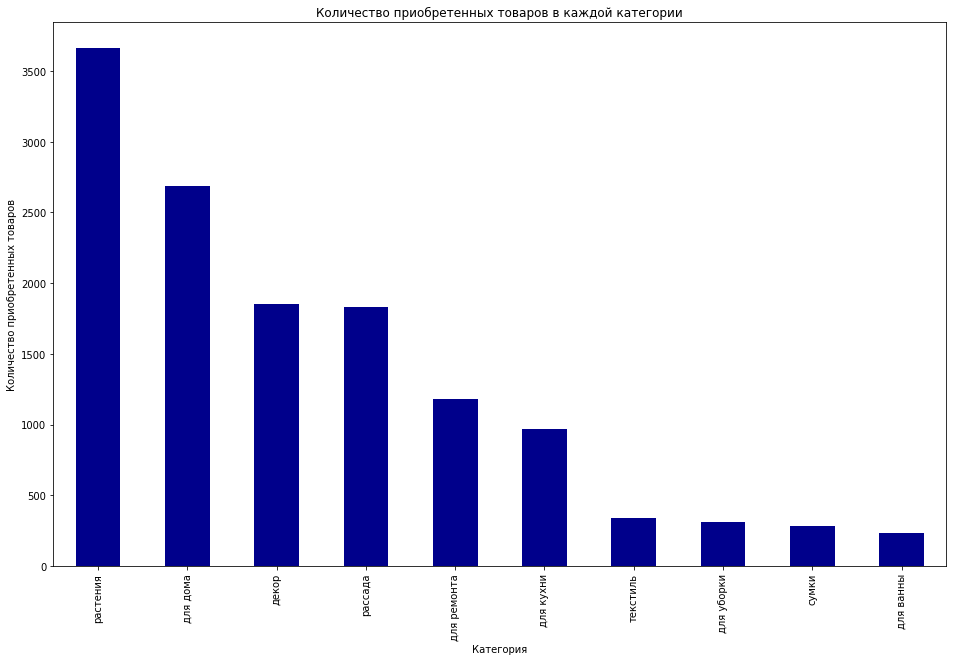

In [67]:
#построим график
category_count.plot(kind='bar', figsize=(16, 10), color='darkblue', legend=False)
plt.title('Количество приобретенных товаров в каждой категории')
plt.xlabel('Категория')
plt.ylabel('Количество приобретенных товаров')
plt.show()

Имеем такую картину:

- лидирует категория "растения" - из нее было приобретено 3 660 товаров
- на втором месте "для дома"- 2 688 товаров
- замыкает лидирующую тройку к тегория "декор" - 1 851 товар

создадим сводную таблицу, которая покажет количество товаров в каждой категории, для дополнения анализа

In [68]:
#определим количество товаров в каждой категории
product_count = data.groupby('category_product').agg({'product': 'nunique'}).sort_values(by='product', ascending=False)
product_count

,product
category_product,
растения,682
для дома,547
рассада,465
для кухни,204
сумки,88
декор,77
для ремонта,73
текстиль,71
для уборки,68


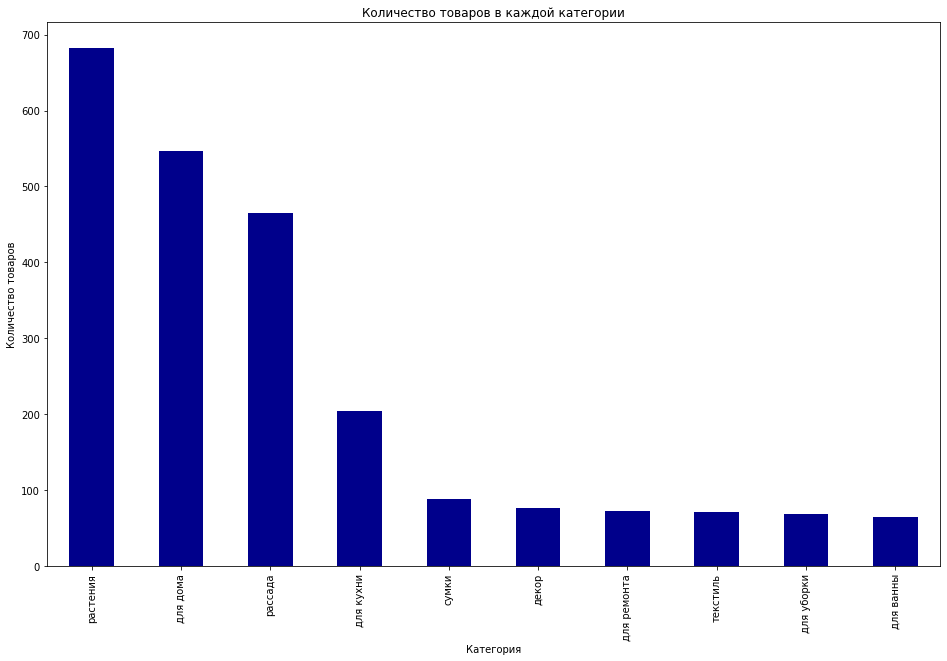

In [69]:
#построим график
product_count.plot(kind='bar', figsize=(16, 10), color='darkblue', legend=False)
plt.title('Количество товаров в каждой категории')
plt.xlabel('Категория')
plt.ylabel('Количество товаров')
plt.show()

- действительно, по количеству товаров категория "растения" является лидирующей
- категория "рассада" переходит на третье место

Рассчитаем общую прибыль и среднюю цену для каждой категории товаров

In [70]:
#определим прибыль по категориям
category_total =  data.groupby('category_product').agg({'full_price': 'sum'}).sort_values(by='full_price',ascending=False)
category_total.astype('int')

,full_price
category_product,
для дома,1403183
сумки,698811
растения,525204
рассада,425916
для кухни,222063
для ремонта,196490
текстиль,170454
для ванны,101572
декор,98659


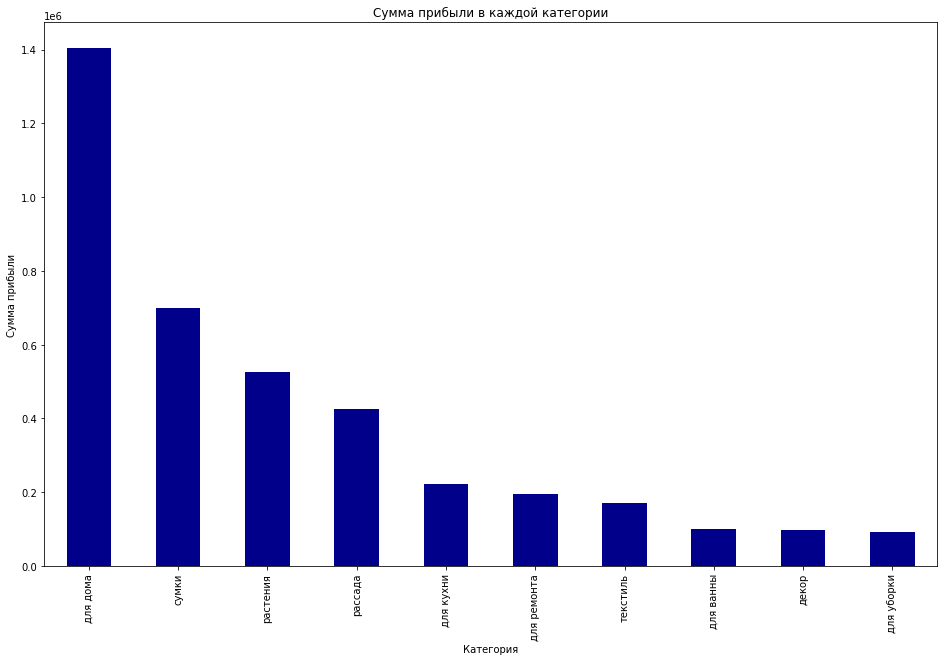

In [71]:
#построим график
category_total.plot(kind='bar', figsize=(16, 10), color='darkblue', legend=False)
plt.title('Сумма прибыли в каждой категории')
plt.xlabel('Категория')
plt.ylabel('Сумма прибыли')
plt.show()

Получается довольно неоднозначная ситуация:

- по доходу со значительным отрывом лидирует категория "для дома" - 1 403 183 ден.ед.
- на втором месте категория "сумки" - 698 811 ден.ед.
- лидирующая по количеству приобретенных товаров на третьем месте с суммой прибыли - 525 204 ден.ед.
- категории "декор" и "для уборки" имеют приблизительно одинаковые значения 98 659 и 93 230 ден. ед. соответсвенно

Вероятно, всё же имеет большое значение цена товаров в каждой категории. Посмотрим на среднюю цену товаров по каждой категории

In [72]:
#рассчитаем среднюю цену товаров по категориям
avg_price = round(data.groupby('category_product').agg({'price': 'mean'}).sort_values(by='price', ascending=False), 0)
avg_price

,price
category_product,
сумки,2492.0
для ремонта,1381.0
для дома,1037.0
для ванны,757.0
текстиль,595.0
для уборки,519.0
для кухни,380.0
рассада,280.0
растения,169.0


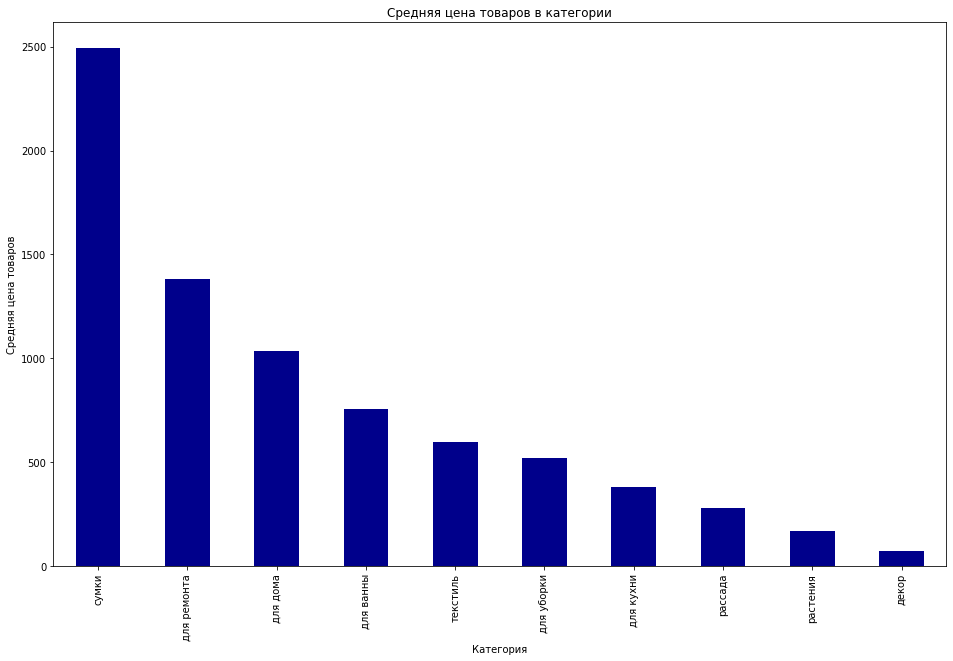

In [73]:
#построим график
avg_price.plot(kind='bar', figsize=(16, 10), color='darkblue', legend=False)
plt.title('Средняя цена товаров в категории')
plt.xlabel('Категория')
plt.ylabel('Средняя цена товаров')
plt.show()

- наибольшую среднюю цену имеет категория "сумки" - 2 492 ден. ед в среднем за одну позицию товара
- с большим отрывом следует категория "для ремонта" - 1 381 ден. ед.
- и категория "для дома" - 1 037 ден. ед.

остальные категории имеют среднюю цену  ниже 1 000 ден. ед за позицию товара

### Сегментация покупателей по категориям количества заказов

Возьмем за основу нашу категоризацию пользователей приложения по количеству заказов.

Продублируем, что у нас есть 3 категории:

- единоразовый - пользователь сделал 1 заказ за всё время
- повторный - покупатель совершил 2 заказа
- периодичный - пользователь сделал 3 или более заказов

В результате такого разделения по количеству пользователей мы имеем следующее:
- единоразовый - 1535 человека
- повторный - 865
- периодичный - 29

Изучим эти категории более подробно. А именно:
- количество товаров, которые приобрела каждая категория
- принесенная прибыль от каждой категории
- категории товаров, которые преимущественно покупают
- средний чек заказа в каждой категории
- частоту заказов

Вначале, разделим наши категории в отдельные датасеты

In [74]:
#разделим на категории
first = data.query("user_type == 'единоразовый'")
second = data.query("user_type == 'повторный'")
third = data.query("user_type == 'периодичный'")

#### Количество приобретенных товаров

In [75]:
#общее количество товаров у 1-й группы
product_one = first['quantity'].sum()
product_one

9625

In [76]:
#общее количество товаров у 2-й группы
product_two = second['quantity'].sum()
product_two

2563

In [77]:
#общее количество товаров у 3-й группы
product_three = third['quantity'].sum()
product_three

1164

По количеству приобретенных товаров:

- категория "единоразовый" приобрела 9 625 товаров
- категория "повторный" приобрела 2 563 товара
- категория "периодичный" приобрела 1 164 товара

Пока всё логично - наибольшая по количеству пользователей категория приобрела наибольшее количество товаров

#### Прибыль от каждой категории

In [78]:
#прибыль 1-й группы
revenue_one = first['full_price'].sum()
revenue_one

2006990.0

In [79]:
#прибыль 2-й группы
revenue_two = round(second['full_price'].sum(), 0)
revenue_two

1572165.0

In [80]:
#прибыль 3-й группы
revenue_three = third['full_price'].sum()
revenue_three

356429.0

- категория "единоразовый" принесла прибыль 2 006 990 ден. ед.
- категория "повторный" принесла прибыль 1 572 165 ден. ед.
- категория "периодичный" принесла прибыль 356 429 ден. ед.
- категория периодичных покупателей по принесённой прибыли заметно отстает

#### Преимущественные категории товаров

In [81]:
#категории 1-й группы
category_one = first.groupby('category_product').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False)
category_one

,quantity
category_product,
растения,2648
для дома,1912
декор,1629
рассада,1147
для ремонта,915
для кухни,716
для уборки,234
текстиль,157
для ванны,138


In [82]:
#категории 2-й группы
category_two = second.groupby('category_product').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False)
category_two

,quantity
category_product,
растения,726
для дома,625
рассада,432
для кухни,215
декор,156
сумки,117
текстиль,92
для ремонта,76
для ванны,62


In [83]:
#категории 3-й группы
category_three = third.groupby('category_product').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False)
category_three

,quantity
category_product,
растения,286
рассада,254
для ремонта,187
для дома,151
текстиль,94
декор,66
для кухни,41
сумки,37
для ванны,33


- наибольшее количество покупок из категории "растения"
- в двух товары "для дома" и "рассада"
- во 1-й и 3-ей "декор" и "для ремонта"

#### Частота заказов

Для определения частоты сначала определим минимальную и максимальную даты заказов для каждой категории

In [84]:
#минимальная дата 1-й группы
min_date_one = first['date'].min()

In [85]:
#максимальная дата 1-й группы
max_date_one = first['date'].max()

In [86]:
#рассчитаем разницу между мин. и макс. датами
delta_one = max_date_one - min_date_one

In [87]:
#подсчитаем количество дней
days_one = delta_one.days
days_one

485

In [88]:
#минимальная дата 2-й группы
min_date_two = second['date'].min()

In [89]:
#максимальная дата 2-й группы
max_date_two = second['date'].max()

In [90]:
#рассчитаем разницу между мин. и макс. датами
delta_two = max_date_two - min_date_two

In [91]:
#подсчитаем количество дней
days_two = delta_two.days
days_two

487

In [92]:
#минимальная дата 3-й группы
min_date_three = third['date'].min()
min_date_three

Timestamp('2018-10-01 00:00:00')

In [93]:
#максимальная дата 3-й группы
max_date_three = third['date'].max()
max_date_three

Timestamp('2019-10-31 00:00:00')

In [94]:
#рассчитаем разницу между мин. и макс. датами
delta_three = max_date_three - min_date_three

In [95]:
#подсчитаем количество дней
days_three = delta_three.days
days_three

395

количество дней:

- для категории second  - 487 дней
- для категории first - 485 дней
- для категории third - 395 дней
- последний заказ пользователей третьей категории (те, кто сделал больше 2-х заказов) был 31 октября. И затем до января 2020 не было ни одного заказа. Это достаточно важный факт, который необходимо учитывать

Определим количество заказов

In [96]:
#для 1-й группы
one = first['order_id'].nunique()
one

1535

In [97]:
#для 2-й группы
two = second['order_id'].nunique()
two

1730

In [98]:
#для 3-й группы
three = third['order_id'].nunique()
three

265

Рассчитаем частоту

In [99]:
#частота для 1-й группы
frequency_one = round(one / days_one, 2)
frequency_one

3.16

In [100]:
#частота для 2-й группы
frequency_two = round(two / days_two, 2)
frequency_two

3.55

In [101]:
#частота для 3-й группы
frequency_three = round(three / days_three, 2)
frequency_three

0.67

Что касается частоты покупок:

- категория "повторный" лидирует
- затем идет категория пользователей с одним заказом
- в конце пользователи с покупками больше 2-х заказов

#### Средний чек

In [102]:
#средний чек для 1-й группы
avg_one = round(revenue_one / one,2)
avg_one

1307.49

In [103]:
#средний чек для 2-й группы
avg_two = round(revenue_two / two, 2)
avg_two

908.77

In [104]:
#средний чек для 3-й группы
avg_three = round(revenue_three / three, 2)
avg_three

1345.02

В среднем клиенты платят за один заказ:

- в категории "единоразовый" - 1 307
- "повторный" - 908
- "периодический" - 1 345

Для более подробной сегментации можно добавить такие данные клиентов:
- пол
- возраст
- семейное положение
- адрес места жительства (населенный пункт)

все эти данные помогут сделать сегментирование пользователей более полным и даст более четкую картину лояльного покупателя

### Портрет лояльного покупателя

Напомним, что цель нашего менеджера - получение прибыли.
Исходя из изученных данных, и так же сегментации покупателей, лояльным покупателем можно назвать пользователя который:

- совершает покупки в категориях "для дома", "рассада", "растения" или "декор". Эти категории наиболее часто используются для пользователей всех сегментов
- совершает 1-2 заказа. Эти пользователи приносят больший доход, по сравнению с покупателями, которые делают заказы периодически
- совершает заказы со средним чеком от 1000 ден. ед

### Итоги раздела

В результате работы с данными в этом разделе:

Категории заказов по суммам:
- преимущественное количество заказов по сумме не превышает 500 ден. ед. Таких заказов у нас 1 894
- категории заказов до 1 000 - 2 000 ден. ед. имеют примерные значения - 684 и 595 заказов
- а самая дорогостоящая категория - более 5 000 ден. ед. имеет всего 43 заказа

В целом можно сказать, что покупатели гораздо чаще делают небольшие и недорогие заказы

Категории пользователей по количеству заказов:
- наибольшее количество пользователей(1 535 человек) за указанный промежуток времени в данных совершили только 1 заказ
- 2 заказа сделали 865 пользователей
- 3 и более заказов сделали всего 29 человек

Большинство пользователей делают заказ единожды - этот вопрос необходимо задать разработчикам прилодения. Возможно, неполадки в работе приложения мешают покупателям взаимодействовать с приложением на постоянной основе

Категории товаров
- все товары были разделены на такие категории - "растения", "декор", "для дома", "рассада", "для кухни", "для ремонта", "для уборки",  "сумки", "текстиль", "для ванны".

По количеству приобретенных товаров в каждой категории:
- лидирует категория "растения" - из нее было приобретено 3 660 товаров
- на втором месте "для дома"- 2 688 товаров
- замыкает лидирующую тройку к тегория "декор" - 1 851 товар

По сумме прибыли в каждой категории:
- по доходу со значительным отрывом лидирует категория "для дома" - 1 403 183 ден.ед.
- на втором месте категория "сумки" - 698 811 ден.ед.
- лидирующая по количеству приобретенных товаров на третьем месте с суммой прибыли - 525 204 ден.ед.
- категории "декор" и "для уборки" имеют приблизительно одинаковые значения 98 659 и 93 230 ден. ед. соответсвенно

По средней цене товаров в категории:
- наибольшую среднюю цену имеет категория "сумки" - 2 492 ден. ед в среднем за одну позицию товара
- с большим отрывом следует категория "для ремонта" - 1 381 ден. ед.
- и категория "для дома" - 1 037 ден. ед.


Сегментация пользователей:
- По количеству приобретенных товаров:
  - категория "единоразовый" приобрела 9 625 товаров
  - категория "повторный" приобрела 2 563 товара
  - категория "периодичный" приобрела 1 164 товара
  
- По принесённой прибыли:
  - категория "единоразовый" принесла прибыль 2 006 990 ден. ед.
  - категория "повторный" принесла прибыль 1 572 165 ден. ед.
  - категория "периодичный" принесла прибыль 356 429 ден. ед.
  - категория периодичных покупателей по принесённой прибыли заметно отстает
  
- По категориям товаров:
  - наибольшее количество покупок из категории "декор"
  - во всех трех категориях в топ-3 товаров попали "растения"
  - в двух товары "для дома"
  - во 2-й и 3-ей "рассада"
  
- По частоте покупок:
  - категория "повторный" лидирует
  - затем идет категория пользователей с одним заказом
  - в конце пользователи с покупками больше 2-х заказов
  
- По среднему чеку за заказ:
  - в категории "единоразовый" - 1 307
  - "повторный" - 908
  - "периодический" - 1 345

Был определен портрет лояльного покупателя. Однако, необходимо проанализировать работу приложения (в т.ч. техническую часть). Более подробные рекомендации для менеджера будут указаны в итогом разделе

## Статистический анализ данных

### Определение гипотез

В этом разделе будет проведён статистический анализ 2 групп гипотез:

Первый набор гипотез - равенство среднего чека среди пользователей двух групп (те, кто сделал 1 заказ и те, кто сделал больше двух) :
- нулевая гипотеза - статистических различий между средними чеками двух групп нет
- альтернативная гипотеза - статистические различия между средними чеками двух групп есть

Мы будем рассматривать именно эти две группы, т.к. при сегментации покупателей средние чеки этих групп примерно одинаковые. Однако, группа пользователей, которые совершили более 2-х заказов во всей остальной сегментации не являются приоритетными (остальные показатели на порядок ниже показателей других групп) 
Проведя статистический анализ, мы сможем более точно понять - будет ли целесообразно давать рекомендации по привлечению внимания этой группы покупателей

Второй набор гипотез - равенство среднего количества товаров в заказе между двух групп (те, кто сделал 1 заказ и те, кто сделал больше двух):
- нулевая гипотеза - среднее количество товаров у двух групп - равное
- альтернативная гипотеза - среднее количество товаров у двух групп - не равное

Здесь мы проверим: есть ли статистические различия по количеству товаров у покупателей с одним заказом или те, кто сделал больше двух. В случае, если нулевая гипотеза не будет опровергнута, можно выдвинуть предположение - для получения большей прибыли более важно не количество заказов каждого покупателя - а количество товаров. Таким образом, передав информацию менеджеру - он может разработать маркетинговую схему, при которой пользователи смогут получать, например, скидку или на следуюший заказ, или, например, на 3(4,5) позицию товара в одном заказе

### Определение метода статистического анализа 

Для первого и второго набора гипотез будем использовать тест Стьюдента, т.к у нас гипотеза о равенстве двух независимых друг от друга выборок. Значение p-value возьмем 0.01 - т.к. по количеству значений выборки у нас достаточно различны, для минимизации ошибки и получения более точных результатов

### Проведение статистического анализа

#### Первый набор гипотез

In [105]:
#рассчитаем средний чек для 1-й группы
mean_price_one = round(first.groupby('order_id').agg({'full_price': 'mean'}), 2)

In [106]:
#рассчитаем средний чек для 3-й группы
mean_price_three = round(third.groupby(['customer_id', 'order_id'])['full_price'].sum().groupby('customer_id').mean(),2)

In [107]:
#проверим гипотезу
results = st.ttest_ind(mean_price_one, mean_price_three)
alpha = 0.01
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: [0.54836653]
Не отвергаем нулевую гипотезу


В результате проведения теста мы не можем на данном моменте отвергнуть нулевую гипотезу (статистических различий между средними чеками двух групп нет)

На основе полученных данных мы добавим рекомендации по 3-ей группе пользователей для менеджера

#### Второй набор гипотез

In [108]:
#рассчитаем количество позиций товара у каждого пользователя
mean_quantity_one = first.groupby('customer_id')['quantity'].sum()

In [109]:
#рассчитаем среднее количество товара для каждого пользователя
mean_quantity_three = round(third.groupby(['customer_id', 'order_id'])['quantity'].sum().groupby('customer_id').mean(), 2)

In [110]:
#проверим гипотезу
results = st.ttest_ind(mean_quantity_one, mean_quantity_three)
alpha = 0.01
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.7530680100763631
Не отвергаем нулевую гипотезу


В этом тесте мы так же не можем отвергнуть нулевую гипотезу(среднее количество товаров у двух групп - равное)

Интерпретацию результата анализа мы добавим в отдел рекомендаций для менеджера

### Итоги раздела

В этом разделе мы определили 2 набора гипотез и провели статистический анализ данных

Первый набор гипотез - равенство среднего чека среди пользователей двух групп (те, кто сделал 1 заказ и те, кто сделал больше двух) :
- нулевая гипотеза - статистических различий между средними чеками двух групп нет
- альтернативная гипотеза - статистические различия между средними чеками двух групп есть

Второй набор гипотез - равенство среднего количества товаров в заказе между двух групп (те, кто сделал 1 заказ и те, кто сделал больше двух):
- нулевая гипотеза - среднее количество товаров у двух групп - равное
- альтернативная гипотеза - среднее количество товаров у двух групп - не равное

Для первого и второго набора гипотез использовали тест Стьюдента.

В результате проведения теста в обоих случаях нет оснований отвергать нулевые гипотезы.

## Заключение

### Общий вывод исследования

В данном проекте у нас были данные интернет-магазина товаров для дома «Пока все ещё тут».

Цель менеджера магазина - увеличение выручки

Была поставлена задача — сегментировать покупателей по профилю потребления на основе предоставленных данных и предоставить рекомендации увеличения прибыли для менеджера

В нашем распоряжении был обновленный датасет, который описывал транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в датасетах :

date — дата заказа;
customer_id — идентификатор покупателя;
order_id — идентификатор заказа;
product — наименование товара;
quantity — количество товара в заказе;
price — цена товара

В результате загрузки и предварительного анализа данных:

- мы имеем датасет в 6 столбцов и количеством строк в каждом - 7 474
- в столбце quantity(количество товара в заказе) минимальное количество товаров - 1, максимальное - 1000. Менеджер говорил о том, что в данных самый большой заказ - тестовый и его не нужно учитывать. Поэтому позже мы исключим этот заказ из наших данных. Среднее значение количество товара в заказе - 1.
- в столбце price (цена товара) минимальная цена товара - 9 ден. ед., в то время как максимальная - 14 917 ден. ед. Среднее значение цены равно 135 ден. ед.
- формат типа данных в колонке date необходимо изменить с int64 на datetime


В результате предобработки данных было выполнено:

- столбец "date" приведён в верный формат данных - datetime64
- добавлены и приведены в нужный формат новые столбцы: "год", "месяц", "день", "итоговая цена"
- данные в столбце "product" приведены в нижний регистр
- удалён тестовый заказ менеджера
- удалены дубликаты
- проведен поиск пропущенных значений
- в результате предобработки, датасет сохранён на 74,3% и увеличено количество столбцов с 6 до 10

В результате проведения исследовательского анализа данных было определено:

- нам представлены данные по заказам из приложения с 1 октября 2018 по 31 января 2020 года
- за указанный промежуток времени в приложении делали заказ 2 429 человек
- было совершено 3 530 заказов
- в среднем, на одного покупателя приходится 1,5 заказа

Количество заказов:

- первые 7 месяцев работы приложения количество заказов было нестабильно - оно постоянно росло и снижалось
- с февраля по апрель 2019 года количество заказов было на порядок выше, чем с мая по ноябрь этого же года
- с августа 2019 года количество заказов стабильно растёт

Изменение выручки по месяцам:

- с октября по декабрь 2018 года доход был довольно высокий - более 340 000 ден.ед.
- начиная с января 2019 года выручка имеет пиковые значения, но постоянно снижается. Сумма выручки не превышает 318 000 ден. ед.
- в отличии от периода октябрь-декабрь 2018 года - аналогичный период 2019 года характеризуется значительным снижением прибыли

Ежемесячное изменение суммы среднего чека заказа:

- изменение среднего чека имеет достаточно хаотичный порядок
- наивысшее значение ср. чека было в ноябре 2018 - 1 762 ден. ед.
- в 2019 году было 2 основных пика значений - январь (1 408) и июнь(1 418)
- наименьшее значение быо в ноябре 2019 года - 594 ден. ед.

Ежемесячное изменение количествa покупателей каждый месяц:

- количество пользователей начиная с августа 2019 года растет. Это вполне хороший показатель
- первые полгода количество покупателей имело скачкообразный характер - больше пользователей пользоваись приложением в декабре, феврале, марте и апреле

В результате работы с данными в разделе сегментации:

Категории заказов по суммам:

- преимущественное количество заказов по сумме не превышает 500 ден. ед. Таких заказов у нас 1 894
- категории заказов до 1 000 - 2 000 ден. ед. имеют примерные значения - 684 и 595 заказов
- а самая дорогостоящая категория - более 5 000 ден. ед. имеет всего 43 заказа
- В целом можно сказать, что покупатели гораздо чаще делают небольшие и недорогие заказы

Категории пользователей по количеству заказов:

- наибольшее количество пользователей(1 535 человек) за указанный промежуток времени в данных совершили только 1 заказ
- 2 заказа сделали 865 пользователей
- 3 и более заказов сделали всего 29 человек
- Большинство пользователей делают заказ единожды - этот вопрос необходимо задать разработчикам прилодения. Возможно, неполадки в работе приложения мешают покупателям взаимодействовать с приложением на постоянной основе

Категории товаров

- все товары были разделены на такие категории - "растения", "декор", "для дома", "рассада", "для кухни", "для ремонта", "для уборки", "сумки", "текстиль", "для ванны".

По количеству приобретенных товаров в каждой категории:

- лидирует категория "растения" - из нее было приобретено 2 419 товаров
- на втором месте "декор" - 2 376 товаров
- замыкает лидирующую тройку категория "для дома" - 2 325 товара

По сумме прибыли в каждой категории:

- со значительным отрывом лидирует категория "для дома" - 1 266 294 ден. ед.
- на втором месте категория "сумки" - 824 270 ден. ед.
- лидирующая по количеству приобретенных товаров на третьем месте с суммой прибыли - 397 954 ден. ед.
- категория "декор", лидирующая по количеству проданных едениц товара находится на последнем месте по прибыли - 135 554 ден. ед.

По средней цене товаров в категории:

- наибольшую среднюю цену имеет категория "сумки" - 2 076 ден. ед в среднем за одну позицию товара
- с большим отрывом следует категория "для ремонта" - 1 152 ден. ед.
- категория "для дома" - 1 097 ден. ед.
- Был определен портрет лояльного покупателя. Однако, необходимо проанализировать работу приложения (в т.ч. техническую часть). 

Цель нашего менеджера - получение прибыли. Исходя из изученных данных, лояльным покупателем можно назвать пользователя который:

- совершает покупки в категориях "для дома", "рассада", "растения" или "декор". Эти категории наиболее часто используютчя для пользователей всех сегментов
- совершает 1-2 заказа. Эти пользователи приносят больший доход, по сравнению с покупателями, которые делают заказы периодически
- совершает заказы со средним чеком от 1000 ден. ед

В  разделе статистического анализа мы определили 2 набора гипотез и провели статистический анализ данных

Первый набор гипотез - равенство среднего чека среди пользователей двух групп (те, кто сделал 1 заказ и те, кто сделал больше двух) :
- нулевая гипотеза - статистических различий между средними чеками двух групп нет
- альтернативная гипотеза - статистические различия между средними чеками двух групп есть

Второй набор гипотез - равенство среднего количества товаров в заказе между двух групп (те, кто сделал 1 заказ и те, кто сделал больше двух):
- нулевая гипотеза - среднее количество товаров у двух групп - равное
- альтернативная гипотеза - среднее количество товаров у двух групп - не равное

Для первого и второго набора гипотез использовали тест Стьюдента.

В результате проведения теста в обоих случаях нет оснований отвергать нулевые гипотезы.

### Рекомендации для менеджера

В данном разделе отдел аналитики укажет основные рекомендации по работе с уже имеющимися данными и последующими, а так же укажем результаты сегментации покупателей:

Были разработаны  3 категории:

- единоразовый - пользователь сделал 1 заказ за всё время
- повторный - покупатель совершил 2 заказа
- периодичный - пользователь сделал 3 или более заказов


Сегментация пользователей:
- По количеству пользователей:
  - единоразовый - 1535 человека
  - повторный - 865
  - периодичный - 29

- По количеству приобретенных товаров:
  - категория "единоразовый" приобрела 9 625 товаров
  - категория "повторный" приобрела 2 563 товара
  - категория "периодичный" приобрела 1 164 товара
  
- По принесённой прибыли:
  - категория "единоразовый" принесла прибыль 2 006 990 ден. ед.
  - категория "повторный" принесла прибыль 1 572 165 ден. ед.
  - категория "периодичный" принесла прибыль 356 429 ден. ед.
  - категория периодичных покупателей по принесённой прибыли заметно отстает
  
- По категориям товаров:
  - наибольшее количество покупок из категории "декор"
  - во всех трех категориях в топ-3 товаров попали "растения"
  - в двух товары "для дома"
  - во 2-й и 3-ей "рассада"
  
- По частоте покупок:
  - категория "повторный" лидирует
  - затем идет категория пользователей с одним заказом
  - в конце пользователи с покупками больше 2-х заказов
  
- По среднему чеку за заказ:
  - в категории "единоразовый" - 1 307
  - "повторный" - 908
  - "периодический" - 1 345
  
  
Рекомендуется:

- провести проверку технического обслуживания приложения: возможно, работа приложения нестабильна. На это указывает несколько факторов:
  - назначение заказам разных покупателей одного id-заказа
  - большое количество дублирующихся заказов в необработанном датасете
  - большинство покупателей делали заказ в приложении только один раз
- проанализировать интерфейс приложения - возможно, одноразовые покупки связаны с неудобством использования приложения (проведение А/В-теста)
- добавить информацию пользователя при регистрации, добавить такие данные:
  - дата рождения
  - возраст
  - добавление этих данных позволит создать большую сегментацию пользователей
- разработать систему лояльности для пользователей: 
  - добавить систему скидок для категории "единоразовый" при покупке, при которой количество позиций товара будет больше определённого числа, установленного менеджером (например, при покупке больше 4-х позиций на последующие позиции будет предоставлена скидка, но при условии оформления одного заказа)
  - при переходе пользователя из категории "единоразовый" в другие - будет происходит и смена системы лояльности
  - для категорий "повторный" и "периодичный" добавить систему поощрения: скидки на последующий заказ или предоставление бонусов(которые покупатель смотеж использовать как скидку на следующий заказ), но с ограничением по времени использования(этот момент позволит взять под контроль эти категории, особенно "периодичный"(последний заказ покупателя из этой категории был в октябре 2019) если пользователи долго не будут формировать последующий заказ - бонусы будут сгорать)
- проанализировать разработанные категории, при необходимости - провести изменения
- провести анализ ассортимента на основе получения прибыли: расширить ассортимент в более доходных категориях, таких как "для дома", "рассада", "растения" и "декор". Эти категории наиболее часто используютчя для пользователей всех сегментов.